In [1]:
import os
import shapely as sp
import shapely.plotting as spplot
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import math
from time import time as Time
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
import src.SlopeBreak2 as slpbr
pd.options.mode.chained_assignment = None

/tmp/ipykernel_640/2381530074.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
allpaths = os.listdir("Saves")
rgts = sorted([int(path) for path in allpaths if "." not in list(path)])

In [3]:
names = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]
cycles = list(range(1, 19))
directory = {rgt:{name:[] for name in names} for rgt in rgts}

In [4]:
for i, rgt in enumerate(rgts):
    for name in names:
        for cycle in cycles:
            filepath = f"Saves/{rgt}/{name}/Bung-{cycle}.json"
            print(f"Checking paths for rgt: {rgt}-{name}-{cycle}", end="    \r")
            if os.path.isfile(filepath) == True:
                directory[rgt][name].append(cycle)

In [5]:
count = {rgt:{name:len(directory[rgt][name]) for name in names} for rgt in rgts}

In [6]:
best = []
for rgt in rgts:
    for name in names:
        if count[rgt][name] >= 13:
            best.append(f"{rgt}-{name}")
print(best)

['415-gt1l', '415-gt1r', '415-gt2l', '415-gt2r', '415-gt3l', '415-gt3r', '461-gt1l', '461-gt1r', '635-gt1l', '635-gt1r', '635-gt2l', '635-gt2r', '635-gt3l', '635-gt3r', '659-gt1l', '659-gt1r', '659-gt2l', '659-gt2r', '659-gt3l', '659-gt3r', '894-gt1r', '894-gt2r', '979-gt1l', '979-gt1r', '979-gt2l', '979-gt2r', '1062-gt1l', '1062-gt1r', '1062-gt2l', '1062-gt2r', '1062-gt3l', '1062-gt3r', '1360-gt1l', '1360-gt1r', '1360-gt2l', '1360-gt2r', '1360-gt3l', '1360-gt3r']


In [7]:
rgt, name = 1062, "gt2l" # RGT and name information
cycles = directory[rgt][name]
print(f"Cycles: {cycles}")
study_area, lim = slpbr.studyArea("Bounds/bungen.gpkg")
xlim, ylim = lim

Cycles: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17]


In [8]:
paths = [f"Saves/{rgt}/{name}/Bung-{cycle}.json" for cycle in cycles]

In [9]:
basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

In [10]:
breaks, qss, plains = [], [], []
for path in paths:
    print(f"Reading file: {path}", end = "               \r")
    track = gpd.read_file(path)
    print(f"Locating Ib for {path}", end = "               \r")
    out = slpbr.findIb(track, gline_xy, debug=False)
    boolib = False
    try:
        track, ibs, qs, plain = out
        if type(ibs) != list and type(ibs) != np.ndarray:
            ibs = [ibs]
        boolib = True
        breaks.append(ibs)
        qss.append(qs)
        plains.append(plain)
    except:
        track = out

In [11]:
breaks

[[2.2353564870572242],
 [2.8234561550436794],
 [2.289351187293775],
 [2.2493179873407527],
 [2.2243254089968474],
 [2.217039060960971],
 [2.216190944952693],
 [2.3285569822414445],
 [2.3615157383608434],
 [2.3674189691944107]]

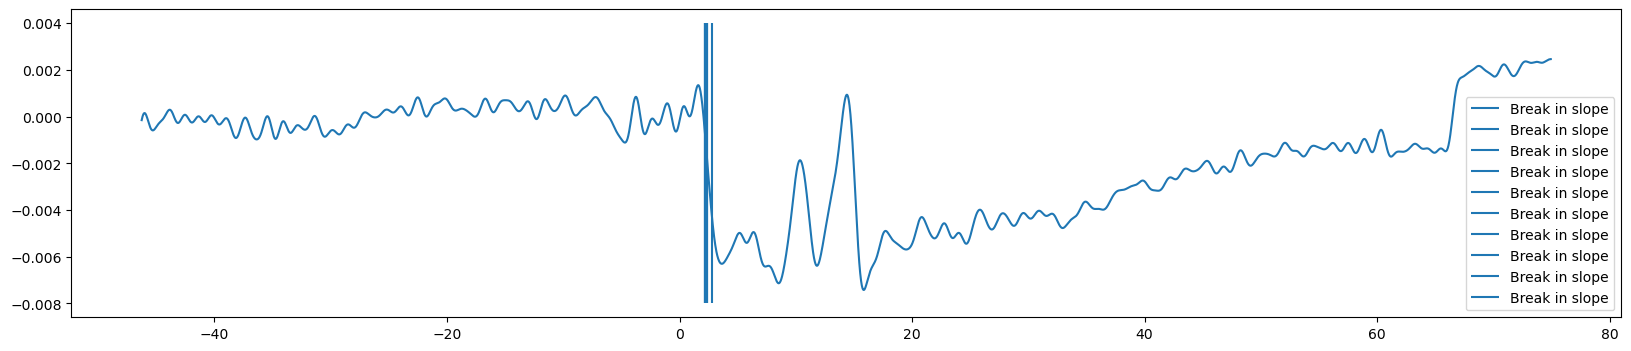

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
#track = gpd.read_file(paths[0])
ax.plot(track["along_dist"], track["slope-filt"])
for ibs in breaks: 
    for ib in ibs:
        ax.vlines(ib, -0.008, 0.004, label = "Break in slope")
#    if plain:
#        ax.vlines(plain, -0.008, 0.004, linestyle="dashed", color="red", label="Ice plain bounds")
plt.legend()
plt.show()